<a href="https://colab.research.google.com/github/LGLV/APS-Failure-at-Scania-Trucks-Data-Set/blob/main/7_4_Panorama_y_acantilados_de_actividad__Similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Activity Cliffs**

---
---


Última modificación: 28-02-2025


---
---


# ***Contenido***
- [***0 - Librerias a emplear***](#0)
- [***1 - Obtención de base de datos***](#1)
  - [**1.1 - Carga y lectura de base de datos**](#1.1)
  - [**1.2 - Pretratamiento de la base de datos**](#1.2)
- [***2 - Diferencias de actividad***](#2)
  - [**2.1 - Implementación 1: ciclo iterativo**](#2.1)
  - [**2.2 - Implementación 2: matriz comparativa**](#2.2)
    - [**2.2.1 - Visualización (Heat map)**](#2.3)
- [***3 - Cálculo de similitud molecular.***](#3)
  - [**3.1 - Implementación 1: ciclo iterativo**](#3.1)
  - [**3.2 - Implementación 2: matriz comparativa**](#3.2)
    - [**3.2.1 - Visualización (Heat map)**](#3.3)
- [***4 - Visualización y análisis de datos***](#4)
  - [**4.1 - SAS map y Panoramas de actividad**](#4.1)
  - [**4.2 - Identificación de *activity cliffs* (ACs)**](#4.2)
     - [*4.2.1 - Establecimiento de umbrales relativos y absolutos*](#4.2.1)
     - [*4.2.2 - Visualización de ACs*](#4.2.2)
- [***5 - Referencias***](#5)



<a name='0'></a>
# ***Librerias a emplear***

In [ ]:
import time
tic =time.time()
from IPython.utils import io # permite uso de instancias "input - output."
import tqdm.notebook
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      pbar.update(20)
      !pip install rdkit
      !pip install molplotly #Libreria, extensión de plotly, para visualización de estructuras en 2D
      !pip install Pillow   # generación de imágenes.
      !pip install jupyter-dash    # librería para la visualización de datos de forma interactiva.
      !pip install dash-bootstrap-components  # diseño de aplicación dash.
      !pip install datamol  # librería para el manejo de moléculas. Documentación: https://github.com/datamol-io/datamol
      !pip install sklearn  # librería para el uso de machine learning en Python. Documentación: https://scikit-learn.org/stable/
      !pip install yellowbrick # librería para la visualización de modelos tipo machine learning. Documentación: https://www.scikit-yb.org/en/latest/
      !pip install molfeat
      !pip install kaleido
      !pip install dash-bootstrap-components
      pbar.update(20)

      import os, sys, random, requests
      import pandas as pd
      import rdkit as rk # URL para consultar documentación y manual de uso: https://www.rdkit.org/docs/
      from rdkit import Chem, DataStructs
      from rdkit.Chem import AllChem, Draw, rdFMCS  # visualización y uso de estructuras.
      from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole, rdDepictor
      rdDepictor.SetPreferCoordGen(True)
      IPythonConsole.drawOptions.minFontSize=25   # Instancias para la creación de imágenes.
      pbar.update(20)
      from rdkit.Geometry import DataStructs
      import numpy as np               # URL para consultar documentación y manual de uso: https://numpy.org/doc/
      from numpy.ma.core import shape
      import math
      import seaborn as sns            # URL para consultar documentación y manual de uso: https://seaborn.pydata.org/
      import matplotlib.pyplot as plt
      import plotly.express as px      # URL para consultar documentación y manual de uso: https://plotly.com/python/
      import plotly.graph_objects as go
      from PIL import Image, ImageDraw, ImageFont   # importación de la librería Pillow, visualización de imagenes, ImageDraw:fuente que desee el usuario
      pbar.update(20)
      from  jupyter_dash import JupyterDash
      import dash
      from dash import dcc, html, dash_table
      from dash.dependencies import Input, Output   # Generación de aplicación web.
      import dash_bootstrap_components as dbc
      from google.colab import files # descargar archivos
      from pydoc import classify_class_attrs
      import base64     # instancias para la codificación de información.
      from io import BytesIO
      import datamol as dm
      from molfeat.calc import FPCalculator, FP_FUNCS
      from molfeat.trans import MoleculeTransformer
      from sklearn.model_selection import train_test_split
      from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
      from yellowbrick.regressor import prediction_error, residuals_plot
      from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,classification_report, confusion_matrix, accuracy_score   # accuracy_score:importación de métricas
      from lightgbm import LGBMRegressor
      from xgboost import XGBRegressor
      import networkx as nx
      from functools import reduce
      pbar.update(20)
toc =time.time()
print("Time: "+ str((toc-tic))+" s")

El objetivo de este estudio de caso es realizar un análisis de similitud química de una serie de compuestos que actúan sobre el target biológico denominado GPR40. Este target es de interés para estudios relacionados a la diabetes tipo II. La base de datos química fue obtenida a partir de CHEMBL.
Los parámetros que serán usados para realizar el análisis de similitud son: IC50 y el Coeficiente de Tanimoto.

<a name='1'></a>

#**Sección 1. Obtención de base de datos.**
La base de datos puede ser cargada a través de dos métodos:
1. Cargando y leyendo el archivo (.csv, .xlsx) directamente
2. Usando la API de ChEMBL.



<a name='1.1'></a>

## Carga y lectura de base de datos:

In [ ]:
url="https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/08_Similitud_GPR40.csv"
database_original_direct = pd.read_csv(url)
print(database_original_direct.info())
database_original_direct[0:2]

<a name='1.2'></a>

## Pretratamiento de la base de datos.
Limpieza de base de datos con la función "*difference*" (únicamente se extraen las columnas de interés).
Para la eliminación de duplicados se considero la representación molecular InChI.

Para cuantificar el panorama de actividad se emplea el **indice SALI **(Indice del panorama estructura-actividad):

    SALI(i,j) = |Ai − Aj|/ 1 − sim(i,j)
El valor SALI será empleado para mapear lo anterior en un mapa SAS usando una escala de color continua desde x(valores bajos SALI) hasta y (valores altos SALI asociados con ACs). Para este segmento consideramos que dos compuestos están conectados si tienen un score SALI superior al limite de corte establecido (mayor al 70 u 80% de todos los scores) https://pubs.rsc.org/en/content/articlehtml/2023/dd/d3dd00098b

In [ ]:
db_treatment = database_original_direct.drop(database_original_direct.columns.difference(['Molecule ChEMBL ID',
                                                                                          'Smiles',
                                                                                          'Standard Value']), axis=1)
db_treatment= db_treatment.rename(columns={'Standard Value':'IC50'})
db_treatment= db_treatment.sort_values(by=['IC50']).reset_index(drop=True) #Ordenamos con respecto a IC50 para obtener una mejor visualización en la siguiente sección


#Creación de la columna "InChI"
InChI_column = []
for i in db_treatment['Smiles']:     # Para cada compuesto 'i' dentro de la base de datos, toma su representación SMILES y conviértela a InChI.
  i = Chem.MolFromSmiles(i)
  n_inchi = Chem.MolToInchiKey(i)
  InChI_column.append(n_inchi)
db_treatment.insert(2, 'InChI', InChI_column) #Adición de columna generada con la representación InChI.


#Creación de columna "pIC50" (-log Ic50)
db_treatment["pIC50"] = db_treatment["IC50"].apply(lambda x: -1 * math.log10(x*(10**-9)))
      # Nota: antes de aplicar el logaritmo, debemos convertir las unidades de valor de IC50 [para este caso en específico, 1 ^ -9 ].

#Eliminación de moléculas duplicados
print(f"Datos originales: {db_treatment.shape}")
db_treatment.drop_duplicates(subset=['InChI', 'Smiles'])
print(f"Datos tras eliminación de duplicados: {db_treatment.shape}")
db_treatment

<a name='2'></a>

#**Sección 2. Diferencias de actividad**

<a name='2.1'></a>

## **Implementación 1: ciclo iterativo.**

Caso de ciclo iterativo para cada compuesto dentro de la base de datos pretratada.



Instrucciones propuestas: creación de una lista que almacena todos los posibles resultados de las comparaciones, posteriormente, se itera sobre cada uno de los compuestos dentro de la base; es decir, se inicia una instancia "for" que pretende recorrer/iterar todos los compuestos. Este ciclo, llamémosle "principal", tiene la funcionalidad de elegir un elemento fijo con el que se va a comparar con el resto de compuestos.

Dentro de esa misma instancia, se inicializa un "sub - ciclo" que pretende recorrer/iterar a la par del ciclo principal todos los compuestos de la base de datos pretratada. Sin embargo, este sub - ciclo tiene la característica de que la variable iterativa inicia una posición por delante del ciclo, pues este sub - ciclo va a comparar el elemento fijo que se elegió en el ciclo principal y el elemento variable que se eligió en este sub - ciclo.

Finalmente, las casos de comparación son almacenados en la lista que se creó en un principio.


In [ ]:
comparacion_actividad = [] #Lista donde se almacenaran las comparaciones

#Ciclo principal de iteración y elección del elemento fijo de comparación
for i in range(len(db_treatment)):
    elemento_fijo = db_treatment.iloc[i]   # nota: 'iloc' solo funciona para localización de datos tipo integers o booleanos.

      # Sub - ciclo: elección de elemento variable y comparación.
    for j in range(i+1, len(db_treatment)):    # "i+1" para asegurarnos de que se empieza a iterar un elemento después del 'elemento_fijo'.
        elemento_variable = db_treatment.iloc[j]

        # Comparación de valores de actividad.
        diferencia_actividad = abs(elemento_fijo["pIC50"] - elemento_variable["pIC50"])

        # Adición de los casos de comparación a la lista de resultados creada en el primer paso.
        comparacion_actividad.append({'Compuesto A': elemento_fijo['Molecule ChEMBL ID'],
                                      'pIC50 A': elemento_fijo['pIC50'],
                                      'Compuesto B': elemento_variable['Molecule ChEMBL ID'],
                                      'pIC50 B': elemento_variable['pIC50'],
                                      'Diferencia de actividad': diferencia_actividad})

# Dataframe con los resultados de comparación.
actividad_db = pd.DataFrame(comparacion_actividad)
actividad_db
# Nota: agregar sección de comprobación de n repeticiones posibles sin repetir. Comprobación  = n(n-1) / 2  ; donde "n" es el número de compuestos dentro de la base de datos.

<a name='2.2'></a>

##**Implementación 2: matriz comparativa**

Lo anterior se puede simplificar al genera una matriz comparativa considerando unicamente los valores de pIC50 y el resultado de la diferencia de actividad.

In [ ]:
%%time
hmap=pd.DataFrame()
for i in db_treatment.index:
    for j in db_treatment.index:
        a = db_treatment.loc[i,'pIC50'] #elemento fijo
        b = db_treatment.loc[j,'pIC50'] #elemento variable
        diferencia_actividad = abs(a - b)
        hmap.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=diferencia_actividad
hmap

<a name='2.3'></a>

###**Visualización (Heat map)**

In [ ]:
palette= sns.blend_palette(['cyan','lightcyan','lightcoral', 'firebrick'],72)
palette

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hmap,square = True, xticklabels=hmap.columns, yticklabels=hmap.index, cmap=palette,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=15) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Diferencia de actividad (∆pIC50)', size=15, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=1)
plt.xticks (np.arange(len(hmap.index))+0.5, hmap.index,rotation=90)
plt.yticks (np.arange(len(hmap.columns))+0.5, hmap.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=8)
plt.show()

<a name='3'></a>

#**Sección 3. Cálculo de similitud molecular.**

En esta sección se generara un loop iterativo para la obtención de fingerprints (radiales del tipo ECFP6 con ayuda de RDKit) y, posteriormente se empleará el coeficiente de Tanimoto para el establecimeinto del cálculo de similitud.

  Nota: pueden utilizarse otro tipo de representaciones moleculares, no necesariamente fingerprints ECFP6.


<a name='3.1'></a>
## **Implementación 1: ciclo iterativo.**

In [ ]:
 tic =time.time()
comparacion_estructura = [] # Lista en donde se almacenan los casos de comparación.
for i in range(len(db_treatment)):
    elemento_fijo_id = db_treatment.loc[[i], ["Molecule ChEMBL ID"]]
    elemento_fijo_df = db_treatment.loc[[i], ["Smiles"]]    # iteración sobre todos los compuestos de la base de datos, en este caso, su representación tipo SMILES.
    elemento_fijo_str = elemento_fijo_df.to_string(index = False, header = False)     # al recorrer/iterar sobre cada uno de los elementos, su reconocimiento no es directamente "string" (que es lo que necesitamos para el método 'GetMorgan'), sino que se obtiene como un "dataframe" por lo que el método "tostring" permite realizar esta conversión.
    elemento_fijo_mol = Chem.MolFromSmiles(elemento_fijo_str)    # al contar con el compuesto en su representación SMILES y en formato string, entoces podemos utilizar RDKit para generar un objeto tipo "mol".
    fps_elemento_fijo = AllChem.GetMorganFingerprintAsBitVect(elemento_fijo_mol, 2, nBits = 1024)  # Morgan toma ese objeto tipo mol y genera un fingerprint. Al mismo tiempo, al utilizar Morgan el usuario tiene que definir un radio a partir el cual se emplea para la generación del fingerprint: en este caso utilizamos "2". El término "n = 1024" es el tamaño del vector de bits generado.

    for j in range(i+1, len(db_treatment)):               #Sub ciclo donde se genera el fingerprint para "elemento_variable".

        elemento_variable_id = db_treatment.loc[[j], ["Molecule ChEMBL ID"]]
        elemento_variable_df = db_treatment.loc[[j], ["Smiles"]]
        elemento_variable_str = elemento_variable_df.to_string(index = False, header = False)
        elemento_variable_mol = Chem.MolFromSmiles(elemento_variable_str)
        fps_elemento_variable = AllChem.GetMorganFingerprintAsBitVect(elemento_variable_mol, 3, nBits = 2048) #ECFP6

        diferencia_estructura = DataStructs.TanimotoSimilarity(fps_elemento_fijo, fps_elemento_variable)

        comparacion_estructura.append({"Compuesto A": elemento_fijo_id.to_string(index = False, header = False),
                                       "Smiles A": elemento_fijo_str,

                                      "Compuesto B": elemento_variable_id.to_string(index = False, header = False),
                                       "Smiles B": elemento_variable_str,

                                      "Similitud estructural (Tanimoto)": diferencia_estructura})

estructura_db = pd.DataFrame(comparacion_estructura)  # dataframe con todas las comparaciones posibles de similitud estructural.
toc =time.time()
print("Time: "+ str((toc-tic))+" s")
estructura_db

# Nota : esta sección de código puede reducirse en la parte de la conversión "dataframe" a "string". Si desde un principio en la base de datos pretratada especificamos "dtype=string" para la columna SMILES ya no es necesario realizar la conversión.

<a name='3.1'></a>

##**Implementación 2: matriz de similitud**

In [ ]:
def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s

In [ ]:
db_treatment.sort_values(by=["Molecule ChEMBL ID"], ascending=False, inplace=True) #Se ordena con respecto al ID para obtener una mejor visualización
db_treatment.reset_index(drop=True, inplace=True)

tic =time.time()
hmap_similarity=pd.DataFrame()
for i in db_treatment.index:
    for j in db_treatment.index:
        a=db_treatment.loc[i].at['Smiles']
        b=db_treatment.loc[j].at['Smiles']
        alignment= tanimoto_calc(a,b)
        hmap_similarity.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")

hmap_similarity

<a name='3.3'></a>

###**Visualización (Heat map)**

In [ ]:
palette= sns.blend_palette(['green','greenyellow','yellow', 'orange'],72)
palette

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hmap_similarity,square = True, xticklabels=hmap_similarity.columns, yticklabels=hmap_similarity.index, cmap=palette,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=15) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Similitud molecular', size=15, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=1)
plt.xticks (np.arange(len(hmap_similarity.index))+0.5, hmap_similarity.index,rotation=90)
plt.yticks (np.arange(len(hmap_similarity.columns))+0.5, hmap_similarity.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=8)
plt.show()

### Determinación de valores SALI

Para cuantificar el panorama de actividad se emplea el indice SALI (Indice del panorama estructura-actividad):


```
# SALIi,j = |Ai − Aj|/1 − sim(i,j)

```
El valor SALI será empleado para mapear lo anterior en un mapa SAS usando una escala de color continua desde x(valores bajos SALI) hasta y (valores altos SALI asociados con ACs).
Para este segmento consideramos que dos compuestos están conectados si tienen un score SALI superior al limite de corte establecido (mayor al 70 u 80% de todos los scores)
https://pubs.rsc.org/en/content/articlehtml/2023/dd/d3dd00098b


In [ ]:
merge=actividad_db.merge(right=estructura_db, on=['Compuesto A', 'Compuesto B']) #Juntamos los DF
merge= merge[['Compuesto A',	'pIC50 A', 'Smiles A','Compuesto B',	'pIC50 B','Smiles B','Diferencia de actividad',	'Similitud estructural (Tanimoto)']]

merge['pIC50 A'] = merge['pIC50 A'].round(4)
merge['pIC50 B'] = merge['pIC50 B'].round(4)
merge['Diferencia de actividad'] = merge['Diferencia de actividad'].round(4)
merge['Similitud estructural (Tanimoto)'] = merge['Similitud estructural (Tanimoto)'].round(4)
merge['Valor de SALI'] = (merge['Diferencia de actividad'] / (1 - merge['Similitud estructural (Tanimoto)'])).round(4)   # para obtener el valor de SALi podemos usar la expresión aritmética directamente sin necesidad de iterar sobre todos los renglones de las columnas.


merge

<a name='4'></a>

#**Sección 4. Visualización y análisis de datos**
La elección de la métrica para definir si algo es un "*activity cliff*" (ACs) depende en gran medida del contexto específico del problema y de los objetivos. Sin embargo, algunas métricas comunes que son posibles de considerar son:


1. **Umbral Absoluto:** Puedes establecer un umbral absoluto para la diferencia de actividad y considerar cualquier diferencia que supere ese umbral como un "activity cliff". Por ejemplo, podrías decidir que cualquier diferencia mayor que 1.5 es un "*cliff*".

2. **Umbral Relativo:** En lugar de un umbral absoluto, podrías considerar un umbral relativo en función de la variabilidad de tus datos. Por ejemplo, podrías definir "*activity cliffs*" como aquellas diferencias que superan cierto múltiplo de la desviación estándar.

3. **Percentil:** Podrías identificar "*activity cliffs*" basándote en ciertos percentiles de la distribución de las diferencias. Por ejemplo, podrías considerar aquellos que están por encima del 90% superior como "*cliffs*".

4. **Criterios Biológicos o Químicos:** Dependiendo del dominio de tu problema, podrías incorporar conocimientos biológicos o químicos para definir "activity *cliffs*". Por ejemplo, podrías considerar como "*cliffs*" aquellas diferencias que conduzcan a cambios significativos en la estructura química.

In [ ]:
# Creamos el heatmap con Plotly
fig = go.Figure(data=go.Heatmap(
    z=merge["Valor de SALI"],
    x=merge["Compuesto B"],
    y=merge["Compuesto A"],
    hoverongaps=False
))

# Configuramos el layout
fig.update_layout(
    title='Heatmap del valor SALI',
    xaxis_title='Compuesto B',
    yaxis_title='Compuesto A'
)

# Mostramos el heatmap
fig.show()

Un valor alto de SALI sugiere que los compuestos son estructuralmente similares pero tienen efectos biológicos o químicos muy diferentes.

<a name='4.1'></a>

##**SAS map o Panorama de actividad**

In [ ]:
fig_scatter = px.scatter(db_treatment,
                         x="Molecule ChEMBL ID",
                         y="pIC50",
                         title='Activity landscape',
                         width=1200,
                         height=800)
# This adds a dashed line for what a perfect model _should_ predict
y = db_treatment["pIC50"].values
fig_scatter.show()

In [ ]:
# Datos del gráfico de dispersión
similitud = merge['Similitud estructural (Tanimoto)']
diferencia_actividad = merge['Diferencia de actividad']
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(similitud, diferencia_actividad, color='gray', alpha=0.5)
plt.title('SAS Map')
plt.xlabel('Similitud estructural (Tanimoto)')
plt.ylabel('Diferencia de actividad')
plt.grid(True)
plt.legend()
plt.show()

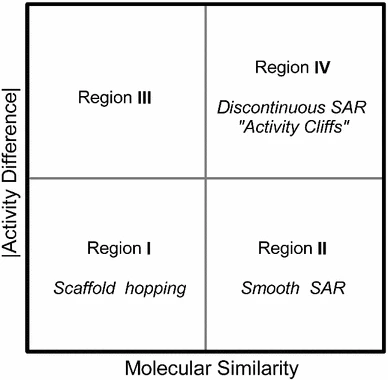

<a name='4.2'></a>
## **Identificación de "activity cliffs" (ACs).**

In [ ]:
def SAS_map(df, similarity_column, dif_activity_col, sali_col, umbral_x=None, umbral_y=None, set_title=str):
    # Crear el gráfico de dispersión
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid", font_scale=1.2)

    plt.scatter(df[similarity_column], df[dif_activity_col], color='gray', alpha=0.2)

    # Si se proporcionan umbrales, identificar los puntos en el cuarto cuadrante
    if umbral_x is not None and umbral_y is not None:
        puntos_cuarto_cuadrante = df[(df[similarity_column] > umbral_x) & (df[dif_activity_col] > umbral_y)]
        plt.scatter(puntos_cuarto_cuadrante[similarity_column], puntos_cuarto_cuadrante[dif_activity_col],
                    c=puntos_cuarto_cuadrante[sali_col], cmap='coolwarm', s=100, alpha=0.8)
        plt.colorbar(label='SALI value')
        plt.axvline(x=umbral_x, color='red', linestyle='--', label='Umbral X')
        plt.axhline(y=umbral_y, color='blue', linestyle='--', label='Umbral Y')
    else:
        plt.scatter(df[similarity_column], df[dif_activity_col],
                    c=df[sali_col], cmap='coolwarm', s=100, alpha=0.8)
        plt.colorbar(label='SALI value')

    plt.title(set_title)
    plt.xlabel(similarity_column)
    plt.ylabel(dif_activity_col)
    plt.grid(True)
    plt.legend()
    return plt.show()

In [ ]:
# Ejemplo de uso sin umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', set_title= 'SAS map')

In [ ]:
'''
El umbral X calculado representa el valor de similitud estructural por encima del cual se encuentran el 10 %
de los pares con la mayor similitud en la base de datos.
El umbral Y corresponde a una unidad logarítmica
'''
similarity_scores=merge['Similitud estructural (Tanimoto)'].tolist()
top_10_percent = int(0.1 * len(similarity_scores)) # Calcula el número de pares en el 10 % superior
sorted_similarity_scores = sorted(similarity_scores, reverse=True) # Ordena las similitudes estructurales de mayor a menor
print(sorted_similarity_scores)
umbral_x = sorted_similarity_scores[top_10_percent - 1] # #El percentil 10 de los compuestos con mayor similitud.
print("Umbral del top 10 %:", umbral_x)
umbral_y = 1  # 1 unidad logarítmica
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=umbral_x, umbral_y=umbral_y, set_title='SAS map')

In [ ]:
print(f"Estadística de la columna 'Diferencia de actividad': {merge['Diferencia de actividad'].describe()}")
print(f"Estadística de la columna 'Similitud estructural (Tanimoto)': {merge['Similitud estructural (Tanimoto)'].describe()}")
print(f"Estadística de la columna 'Valor de SALI': {merge['Valor de SALI'].describe()}")

Considerando la información anterior, podemos establecer dos tipos de umbrales, unos absolutos (25%, 50%, 75%) y unos realtivos considerando:
1. Diferencia de Actividad (pIC50):
    - Dado que la media es 1.388 y la desviación estándar es 0.990511, se podría considerar umbrales que estén en el rango de 1 a 2 desviaciones estándar de la media.
    Por ejemplo, podriamos definir como "alta" diferencia de actividad aquellas mayores que, por ejemplo, 2.5 (media + 2 * desviación estándar).
2. Similitud Estructural (Tanimoto):
  - Podrías definir como "alta" similitud aquella mayor que, por ejemplo, 0.482 (media + 2 * desviación estándar).

<a name='4.2.1'></a>

### **Establecimiento de umbrales relativos y absolutos**

In [ ]:
#Umbrales absolutos--->  considerando el 25%, 50% y 75% en ambos casos
thresholds_ActivityDiff_25= 0.600000
thresholds_Similarity_25 = 0.111100
thresholds_ActivityDiff_50= 1.210000
thresholds_Similarity_50 = 0.136400
thresholds_ActivityDiff_75= 2.023100
thresholds_Similarity_75 = 0.237950

In [ ]:
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=thresholds_Similarity_25, umbral_y=thresholds_ActivityDiff_25, set_title='SAS map 25%')

In [ ]:
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=thresholds_Similarity_50, umbral_y=thresholds_ActivityDiff_50, set_title='SAS map 50%')

In [ ]:
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=thresholds_Similarity_75, umbral_y=thresholds_ActivityDiff_75, set_title='SAS map 75%')

In [ ]:
#Umbrales Relativos considerando promedio + 2 veces la desviación estandar
thresholds_ActivityDiff_rel= merge['Diferencia de actividad'].mean() + 2 * merge['Diferencia de actividad'].std()
thresholds_Similarity = merge['Similitud estructural (Tanimoto)'].mean() + 2 * merge['Similitud estructural (Tanimoto)'].std()
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=thresholds_Similarity, umbral_y=thresholds_ActivityDiff_rel, set_title='SAS map prom+2sdt%')

In [ ]:
#Umbrales Relativos considerando promedio + 2 veces la desviación estandar y una diferencia de actividad menor a 0.1
y_cut_value_cliffs = 0.1
# Ejemplo de uso con umbrales
SAS_map(merge, similarity_column='Similitud estructural (Tanimoto)', dif_activity_col='Diferencia de actividad',
        sali_col='Valor de SALI', umbral_x=thresholds_Similarity, umbral_y=y_cut_value_cliffs, set_title='SAS map prom+2sdt%')


<a name='4.2.2'></a>

### **Visualización de ACs**

In [ ]:
"""import kaleido
from kaleido.scopes.plotly import PlotlyScope
# Import specific visualization tool for chemical structures
import molplotly
from dash import dcc, html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash"""

In [ ]:
import molplotly
def visualizacion_activity_cliffs_dinamico(df, title='', umbral_x=None, umbral_y=None, port = 8780):
    # Filtrar datos si se proporcionan umbrales
    if umbral_x is not None and umbral_y is not None:
        df_filtered = df[(df["Similitud estructural (Tanimoto)"] > umbral_x) &
                         (df["Diferencia de actividad"] > umbral_y)]
    else:
        df_filtered = df.copy()

    # Crear la visualización principal
    fig_sasmap = px.scatter(
        df_filtered,
        x="Similitud estructural (Tanimoto)",
        y="Diferencia de actividad",
        color="Valor de SALI",
        color_continuous_scale=['blue', 'red'],
        hover_data=["Compuesto A", "Compuesto B"]
    )

    # Agregar moléculas con MolPlotly
    smiles_cols = ['Smiles A','Smiles B']

    app_maker = molplotly.add_molecules(fig=fig_sasmap, df=df_filtered, smiles_col=smiles_cols, caption_cols=['Compuesto A', 'Compuesto B',   'Valor de SALI'])

    # Determinar el entorno (Colab/Jupyter o local)
    try:
        # Si estamos en Jupyter o Colab
        app_maker.serve_kernel_port_as_iframe()
    except AttributeError:
        # Si estamos en un entorno local
        app_maker.run_server(mode='inline', port=port, height=600, debug=False, threaded=True)


    #return fig_sasmap.show()

In [ ]:
# Llamar a la función con el dataframe `merge`
visualizacion_activity_cliffs_dinamico(merge, title='SAS Map')

In [ ]:
# Ejemplo de uso con umbrales
visualizacion_activity_cliffs_dinamico(merge, title='SAS Map', umbral_x=umbral_x, umbral_y=1, port=8540)

In [ ]:
!kill $(lsof -t -i:8064)  # Reemplaza el puerto 8064 con el que estás utilizando

<a name='5'></a>

# ***Referencias***:
* Bajorath, Jürgen. 2014. “Exploring Activity Cliffs from a Chemoinformatics Perspective.” Molecular Informatics 33 (6-7): 438–42.
* David, Laurianne, Amol Thakkar, Rocío Mercado, and Ola Engkvist. 2020. “Molecular Representations in AI-Driven Drug Discovery: A Review and Practical Guide.” Journal of Cheminformatics 12 (1): 56.
* Pérez-Villanueva, Jaime, Oscar Méndez-Lucio, Olivia Soria-Arteche, and José L. Medina-Franco. 2015. “Activity Cliffs and Activity Cliff Generators Based on Chemotype-Related Activity Landscapes.” Molecular Diversity 19 (4): 1021–35.
